<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Sistema inteligente para ayudar a detectar posibles reclamos (glosas) en las cuentas médicas previo al cobro, de una clínica en Colombia - Audimed</h1></center>
<center><h2>Trabajo Fin de Master<br>Máster Universitario en Análisis y Visualización de Datos Masivos / Visual Analytics and Big Data</h2></center>

<h3>Presentado por: Jacqueline Guzmán Rodriguez</h3>
<h4>Tipo de trabajo: Desarrollo Software <br>
Director: Juan Carlos Rincon Acuña <br>
Fecha: Junio/2024</h4>

<h3> <font color="#040078">Notebook de modelado de los datos</font></h3>
<h4></h4>
<h5><font color="#C62400">Licencia del Notebook CC BY-NC-SA 4.0 DEED <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/" target="_blank]">https://creativecommons.org/licenses/by-nc-sa/4.0/</a></font></h5/>

## Importación de librerias necesarias

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn_evaluation import plot

## Carga de archivo con datos transformados claims.cvs
#### Se pueden descargar los datos de la plataforma kaggle en el siguiente link: 
##### https://www.kaggle.com/datasets/jacquelineguzman/claims-of-medical-billing/

In [2]:
# Read file CSV Download of https://www.kaggle.com/datasets/jacquelineguzman/claims-of-medical-billing/
file_cvs = "claims.csv"
# Create dataframe with information of file CSV
df = pd.read_csv(file_cvs, delimiter=',', encoding='utf-8')

## Tratamiento de datos previos a la aplicación del modelo de clasificación
##### Se define como variable objetivo la marca de si el registro tiene reclamación o no (CLAIM)

In [3]:
# Define colums target (CLAIM)
columns = df.columns
target = "CLAIM"
x_columns = columns.drop(target)

##### Se actualizan las variables para manejar tipos de datos a 32 bits, dado que usa menos recurso de memoria.

In [4]:
# Update datatype int64 to int32 and float64 to float32, because it is necessary to use less RAM
float_columns = ['QUANTITY_PRODUCT_SERVICE', 'SALES_PRICE', 'INVOICED_PRICE']
int_columns = columns.drop(float_columns)
df[float_columns]=df[float_columns].astype(np.float32)
df[int_columns]=df[int_columns].astype(int)

##### Para facilitar los calculos del algoritmo se normaliza la información de las variables de entrada para que manejen rangos numericos entre cero (0) y uno (1), esto se hace con la función MinMaxScaler

In [5]:
# Normalize data via MinMaxScaler function
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=columns)

##### Se verifica la distribucción de la variable objetivo (CLAIM), donde se observa que es desbalanceda.

In [6]:
# Distribution of the target variable (CLAIM)
print(str(target)+':\n'+str(df[target].unique())+'\n')
print(df[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    6104323
1.0        120
Name: count, dtype: int64


##### Se crean los dataframe de entrada (ValX) y salida (ValY) 

In [7]:
# Create dataframe with int variables (ValX) and target variable (ValY)
ValX = df.drop(columns=target)
ValY = df[target]

##### Se crean los dataframe de entrenamiento y validación, necesarios para el entrenamiento del modelo, se definió un 15% de los datos para los dataframe de validación

In [8]:
# Set training and validation data
X_train, X_validation, Y_train, Y_validation = train_test_split(ValX, ValY, test_size=0.15, random_state=1, shuffle=True)
X_train.shape, X_validation.shape

((5188776, 53), (915667, 53))

##### Para no trabajar con datos de entrenamiento desbalanceados, se aplica la técnica de sobremuestreo (over-sampling) sobre los datos de entrenamiento (X_train y Y_train)

In [9]:
# Resampling the minority class using SMOTE stategy (Over-sampling)
sm = SMOTE(sampling_strategy='minority', random_state=42)

In [10]:
# Fit the model to generate the data.
X_train, Y_train = sm.fit_resample(X_train, Y_train)

C:\Users\jefe.sistemas\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jefe.sistemas\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [11]:
X_train.shape, X_validation.shape

((10377344, 53), (915667, 53))

## Creación del modelo
##### Se escoge el algoritmo de Random Forest de clasificación, dado que tenemos una variable objetivo con dos clases (0, 1)
##### Para verificar los hiperparametros, se hicienron procesos de prueba y error obteniendo los siguientes: n_estimators=5, con 5 arboles es suficiente, y con 10 ramas tambien max_depth=10

In [12]:
# Model random forest classifier
#,class_weight="balanced"
RFC_model = RandomForestClassifier(n_estimators=100, max_depth=53, class_weight="balanced_subsample")
RFC_model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=53)

### Validación del modelo
##### Crear datase con los datos que predice el modelo (Y_predict), basado en los datos de validación X_validation

In [13]:
Y_predict = RFC_model.predict(X_validation)

In [14]:
print('Model accuracy score with 5 decision-trees : {0:0.4f}'. format(accuracy_score(Y_validation, Y_predict)))

Model accuracy score with 5 decision-trees : 1.0000


##### Verificar la salida esperada con la salida de la predicción

In [15]:
df_compare = pd.DataFrame({'Actual value': Y_validation, 'Predicted value': Y_predict})
df_compare.tail(10)

,Actual value,Predicted value
3141433,0.0,0.0
3895887,0.0,0.0
2199388,0.0,0.0
2010216,0.0,0.0
5153739,0.0,0.0
6054309,0.0,0.0
1411925,0.0,0.0
596122,0.0,0.0
5236999,0.0,0.0
4092770,0.0,0.0


In [16]:
sumary = pd.DataFrame({'Actual value': df_compare['Actual value'].value_counts(), 'Predicted value': df_compare['Predicted value'].value_counts()})
sumary.head()

,Actual value,Predicted value
0.0,915651,915648
1.0,16,19


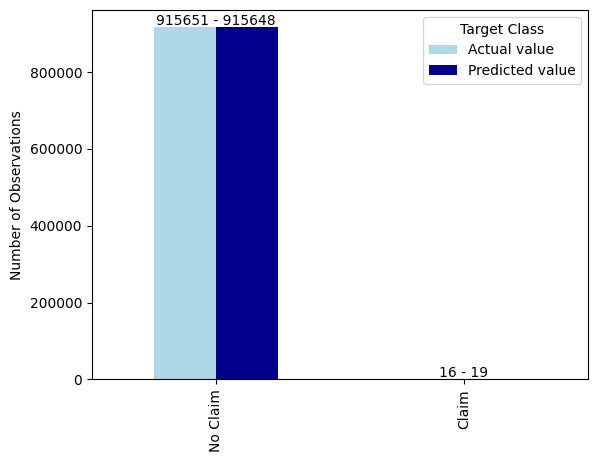

In [17]:
val_no_claim_valida=str(sumary['Actual value'][0])
val_no_claim_predict=str(sumary['Predicted value'][0])
val_no_claim=val_no_claim_valida+' - '+val_no_claim_predict
#print(val_no_claim)
val_claim_valida=str(sumary['Actual value'][1])
val_claim_predict=str(sumary['Predicted value'][1])
val_claim=val_claim_valida+' - '+val_claim_predict
#print(val_claim)
bar_colors = ['lightblue', 'darkblue']
sumary.plot.bar(color=bar_colors)
plt.xticks(range(2), ["No Claim","Claim"])
plt.text(0, sumary['Actual value'][0], val_no_claim, ha='center', va='bottom')
plt.text(1, sumary['Actual value'][1], val_claim, ha='center', va='bottom')
#plt.xlabel("Target Class")
plt.ylabel("Number of Observations")
plt.legend(title="Target Class")
plt.show()

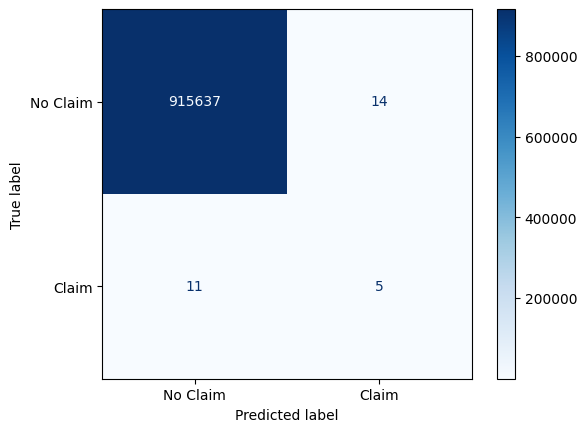

In [18]:
confusion_matrix = confusion_matrix(df_compare['Actual value'], df_compare['Predicted value'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Claim', 'Claim'])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
print(classification_report(df_compare['Actual value'], df_compare['Predicted value']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    915651
         1.0       0.26      0.31      0.29        16

    accuracy                           1.00    915667
   macro avg       0.63      0.66      0.64    915667
weighted avg       1.00      1.00      1.00    915667



In [20]:
from sklearn.metrics import precision_score
precision_score(Y_validation, Y_predict)

0.2631578947368421

In [21]:
from sklearn.metrics import recall_score
recall_score(Y_validation, Y_predict)

0.3125

In [22]:
from sklearn.metrics import f1_score
f1_score(Y_validation, Y_predict)

0.2857142857142857

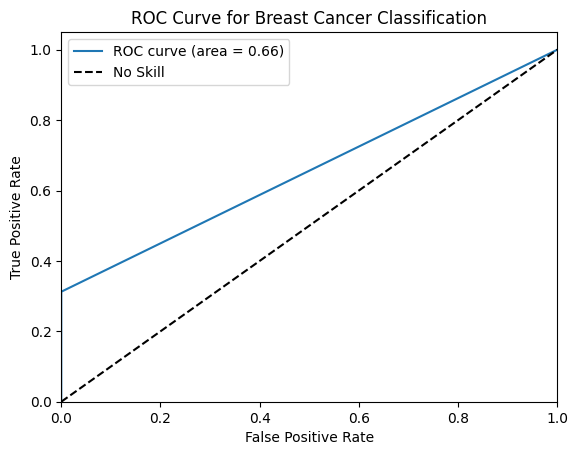

In [23]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_validation, Y_predict) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

In [24]:
# True positive = 913.707
# True negative = 14
# False positive = 2
# False negative = 1.944
# Negatives = 913.707 + 1.944 = 915.651
# Positives = 2 + 14 = 16
TN=913707
TP=14
FN=2
FP=1944
N=915641
P=16
Accuracy = (TP+TN)/(P+N)
Error_rate = (FP+FN)/(P+N)
Precision_true = TP/(TP+FP)
Precision_false = TF/(TF+FN)
TPrate_true = TP/P
TPrate_true = TN/N


NameError: name 'TF' is not defined

In [ ]:
R-squared: Al ser muy cercano a Uno es un modelo muy confiable (Coeficiente de determinación)
TPR: 0.99649102
Precisión: 0.99999671
Alta precesión y alto TPR El modelo maneja muy bien la clase